In [12]:
# 라이브러리
import os
import pandas as pd
import numpy as np

# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import torch
import random

In [13]:
def reset_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)    # 파이썬 환경변수 시드 고정
    np.random.seed(seed)
    torch.manual_seed(seed) # cpu 연산 무작위 고정
    torch.cuda.manual_seed(seed) # gpu 연산 무작위 고정
    torch.backends.cudnn.deterministic = True  # cuda 라이브러리에서 Deterministic(결정론적)으로 예측하기 (예측에 대한 불확실성 제거 )

CSV 로드

In [14]:
# hotel폴더의 archive폴더에 있는 CSV로드
import easydict
args = easydict.EasyDict()

args.default_path = './archive/hotel_bookings.csv'

# 데이터 분석을 위한 변수들
args.random_state = 21

# Load hotel Data

In [15]:
plt.style.use('fivethirtyeight')
plt.ion()

import warnings
warnings.filterwarnings('ignore')

In [16]:
df = pd.read_csv(args.default_path)
df.shape

(119390, 32)

In [19]:
hotel_counts = df['hotel'].value_counts()
print(hotel_counts)

hotel
City Hotel      79330
Resort Hotel    40060
Name: count, dtype: int64


In [22]:
total_of_special_requests_counts = df['total_of_special_requests'].value_counts()
print(total_of_special_requests_counts)

total_of_special_requests
0    70318
1    33226
2    12969
3     2497
4      340
5       40
Name: count, dtype: int64


In [23]:
customer_type_counts = df['customer_type'].value_counts()
print(customer_type_counts)

customer_type
Transient          89613
Transient-Party    25124
Contract            4076
Group                577
Name: count, dtype: int64


In [24]:
stays_in_weekend_nights_counts = df['stays_in_weekend_nights'].value_counts()
print(stays_in_weekend_nights_counts)

stays_in_weekend_nights
0     51998
2     33308
1     30626
4      1855
3      1259
6       153
5        79
8        60
7        19
9        11
10        7
12        5
13        3
16        3
14        2
19        1
18        1
Name: count, dtype: int64


결측치 확인

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [8]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [9]:
# df['company'].unique()
# df['agent'].unique()
# df['country'].unique()
df['children'].unique()

array([ 0.,  1.,  2., 10.,  3., nan])

is_canceled
0    62.958372
1    37.041628
Name: proportion, dtype: float64


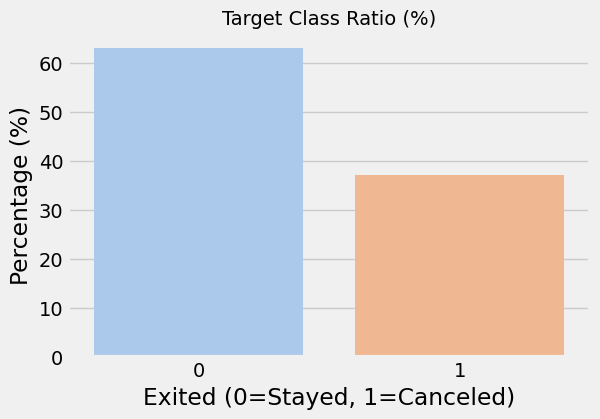

In [10]:
#타깃 불균형 확인 -> 타깃 불균형치 높음(0: 65%, 1: 35%) ==> class_weight, SMOTE 등 써야 함
target_ratio = df['is_canceled'].value_counts(normalize=True) * 100
print(target_ratio)

plt.figure(figsize=(6,4))
sns.barplot(x=target_ratio.index, y=target_ratio.values, palette='pastel')
plt.title('Target Class Ratio (%)', fontsize=14)
plt.xlabel('Exited (0=Stayed, 1=Canceled)')
plt.ylabel('Percentage (%)')
plt.show()

# 칼럼 설명


## ✅ 수치형 (Numeric Features)
### 연속형 + 이산형 숫자들
- lead_time
- arrival_date_year
- arrival_date_day_of_month    → 도착년도 월일을 범주형의 예약날짜, 확정일 경과시간과 비교할것
- stays_in_weekend_nights
- stays_in_week_nights  → 주중과 주말 숙박일 수를 합쳐 하나의 피쳐 생성
- adults
- children
- babies   → 어른과 어린이 수 와 함깨 합쳐 하나의 피쳐 생성
- is_repeated_guest   →  첫방문과 재방문 여부
- previous_cancellations   →  이전 예약 취소 횟수
- previous_bookings_not_canceled   →  취소하지 않은 횟수
- booking_changes    →  예약 변경 횟수
- days_in_waiting_list   →  대기 리스트에 있는 일수
- adr (평균 일일 요금)
- required_car_parking_spaces   →  요청 주차공간 (가족수와 비교할것 가족수가 많으면 요구 주차대수 늘어날 것으로 보임)
- total_of_special_requests   →  특별 요청 개수 (특별 요청이 많을수록 추가 비용 발생 가능성 따라서 예약비용이 올라갈 것으로 보임)

## ✅ 범주형 (Categorical Features)
### 문자열 또는 ID 같은 비연속형

- hotel   →  도시형, 시골형
- arrival_date_month   →  월형태이므로 순서형으로 변환(도착년, 월 합칠것)
- meal   →  식사 포함 여부(금액에 영향을 줄 것으로 보임)
- reserved_room_type   →  예약 객실 유형
- assigned_room_type   →  실제 받은 객실 유형 (예약 객실 유형과 비교할 것)
- deposit_type   →  보증금 유형 (보증금 유형에 따라 취소 가능성 다를 것, 비쌀수록 안하겠지)
- customer_type   →  단기인가 장기인가(예약 형태와 관련)
- reservation_status   →  예약 상태
- reservation_status_date   →  예약날짜

## 불필요한 컬럼
- agent (숫자지만 ID 개념 → 범주형처럼 쓸 수도 있음)
- company (숫자지만 ID 개념 → 범주형처럼 쓸 수도 있음)
- arrival_date_week_number
- country (너무 많음 도착 나라가 취소에 영향이 있을까?)
- market_segment (예약 경로가 취소에 영향이 있을까?)
- distribution_channel (unique에서 알수 없는 정보 포함)

수치형 데이터 확인

In [11]:
df_tmp1 = df.drop(['agent', 'company', 'arrival_date_week_number', 'country', 'market_segment', 'distribution_channel'], axis=1)
df_tmp1.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,391.000000,5400.000000,8.000000,5.000000


- is_canceled
평균: 0.37 → 전체 예약 중 37%가 취소됨
0/1 값 → 이진 타겟 변수

- lead_time (리드타임)
평균: 104일, 최대: 737일 → 예약 후 도착까지 걸린 일수
긴 리드타임은 취소 가능성이 커질 수 있음

- arrival_date_year / arrival_date_day_of_month
연도: 2015~2017 데이터
날짜는 1~31일 분포

- stays_in_weekend_nights / stays_in_week_nights
평균 주말 숙박: 0.9박, 주중 숙박: 2.5박
최대 19박(주말), 50박(주중) → 비정상적으로 긴 체류는 아웃라이어 가능

- adults / children / babies
평균 성인: 1.85명, 아이: 0.10명, 아기: 0.007명
children 결측치 있었음 (119386/119390) → 4건 NaN

- is_repeated_guest
평균 0.031 → 약 3%만 재방문 고객

- previous_cancellations / previous_bookings_not_canceled
일부 고객은 최대 26번 취소, 72번 예약 경험 있음 → extreme outlier

- booking_changes
예약 변경 평균 0.22회, 최대 21회 → outlier 가능

- days_in_waiting_list
평균 2.3일, 최대 391일 → 어떤 예약은 1년 넘게 대기 상태

- adr (평균 일일 요금)
평균 101.8, 최대 5400 → 극단치 있음 → 이상치 처리 필요
최소 -6.38 → 음수 요금 이상치 존재!

- required_car_parking_spaces
평균 0.06 → 대부분 주차공간 필요 없음
total_of_special_requests

- total_of_special_requests
평균 0.57개, 최대 5개 → 고객 맞춤 요청 (예: 침대 추가, 조식 등)

adr 음수 값 → 이상치 처리 필요

stays_in_week_nights 50박, adults 55명 → 비정상치 제거 필요

children NaN → 소수라서 median/0으로 대체 가능 (나이를 의미하는 것으로 보임)

days_in_waiting_list 최대 391일 → 분석 목적 따라 trim 필요

범주형 데이터 확인

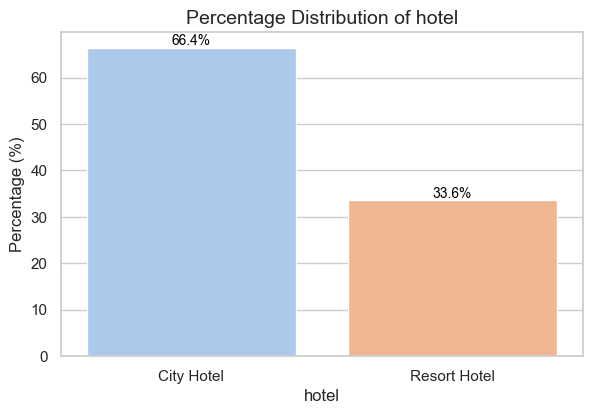

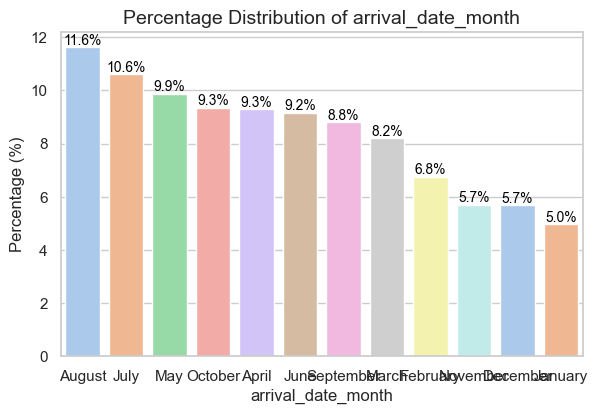

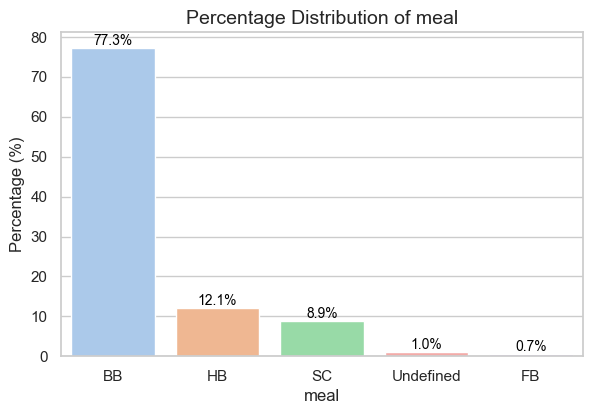

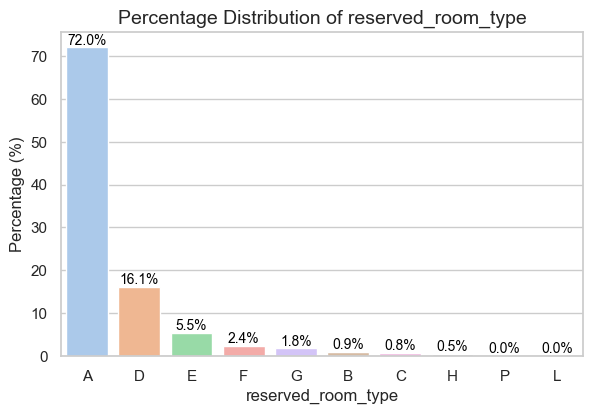

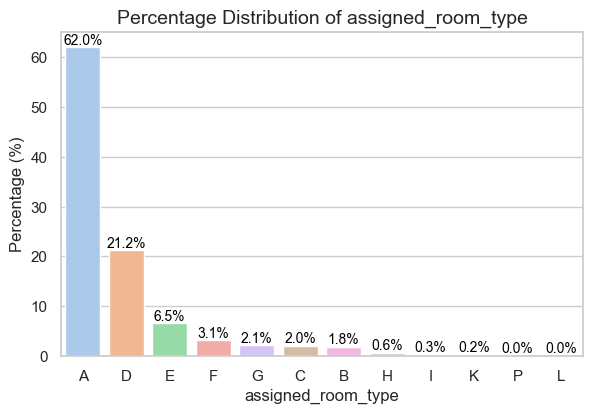

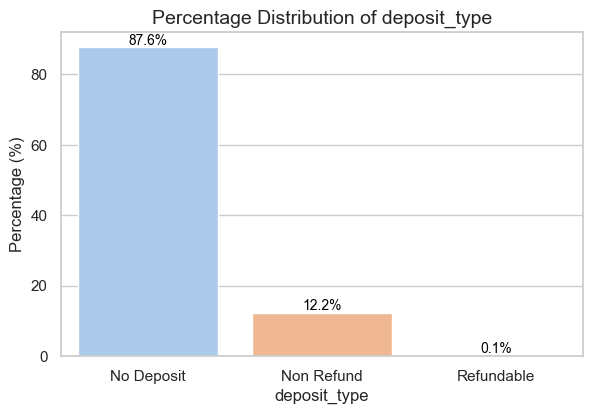

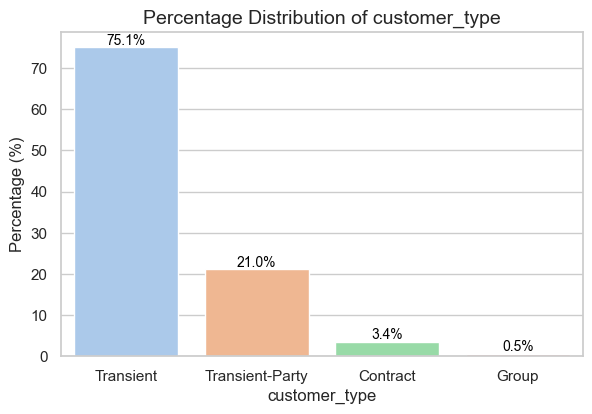

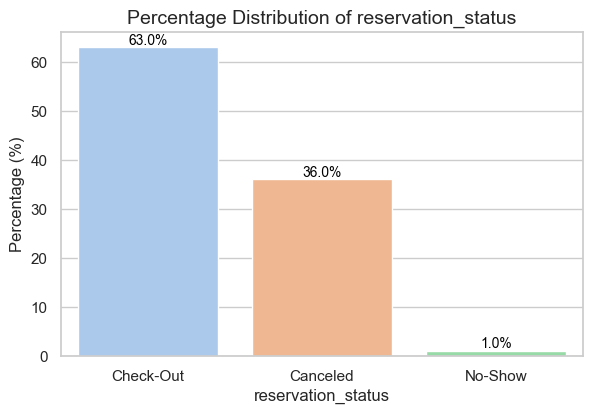

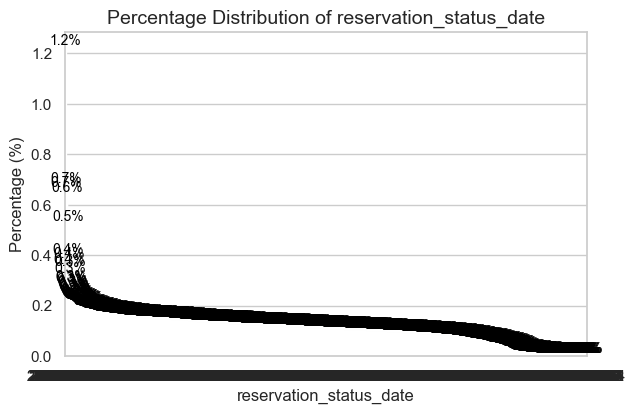

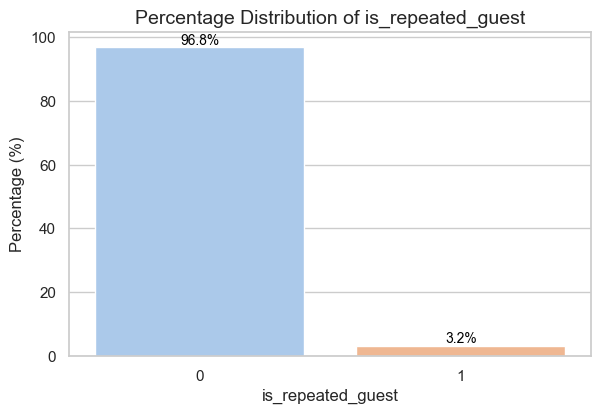

In [9]:
sns.set(style="whitegrid", palette="pastel")
plt.rcParams['figure.figsize'] = (6, 4)

# 범주형 컬럼 리스트
cat_cols = ['hotel', 'arrival_date_month', 'meal', 'reserved_room_type', 'assigned_room_type', 'deposit_type','customer_type', 'reservation_status','reservation_status_date', 'is_repeated_guest']

for col in cat_cols:
    plt.figure(figsize=(6,4))

    # 비율 계산
    dist = df[col].value_counts(normalize=True) * 100

    # 막대그래프 그리기
    ax = sns.barplot(x=dist.index, y=dist.values, palette='pastel')
    plt.title(f'Percentage Distribution of {col}', fontsize=14)
    plt.ylabel('Percentage (%)')
    plt.xlabel(col)

    # 각 막대 위에 비율 표시
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black',
                    xytext=(0, 5), textcoords='offset points')

    plt.show()

- city : resort = 66 : 33
월은 계절로 묶으면 좋아보임
식사 제공 - 대부분 BB 조식만 제공
HB : 저녁, 조식
FB : 3식
SC : 식사 미포함

- 예약 Room type
A : 72%
D : 16%
E : 5%
F : 2.4%
G : 1.8%
정리를 하거나 날리는게 좋아보임, 혹은 금액과비교

- 제공 받은 방
A : 62%
D : 21%
E : 6.5%
F : 3.1%
G : 2.1%
C : 2%
B : 1.8%
예약한 방과 제공받은 방의 차이를 비교해볼것

0.* 타입은 정리하고 최빈값으로 체우기

- 보증금
없음 : 안돌려줌 = 87% : 12:
0.1퍼는 없음으로 채우기

- 고객유형
"Transient" (단기 투숙객, 개인),
"Contract" (계약 고객, 기업 등),
"Group" (단체 고객) : 정리 필요,
"Transient-Party" (일부 단체와 함께 예약한 단기 고객)

- 예약 상태
체크 아웃 : 취소 : 노쇼 = 63: 36 : 1
노쇼는 취소랑 합칠것


- 예약 상태 날짜는 월단위로 잘라서 정리할것


각 범주형 데이터를 취소 여부와 비교해봄

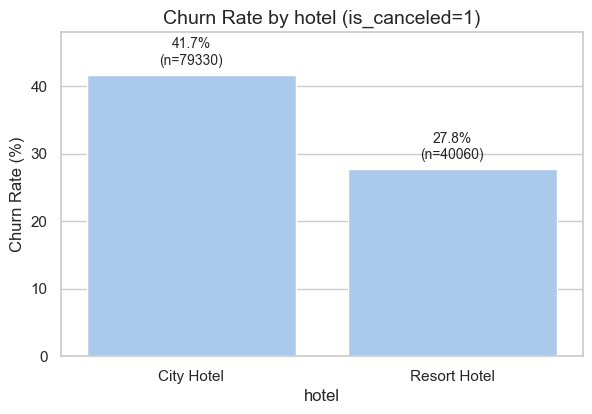

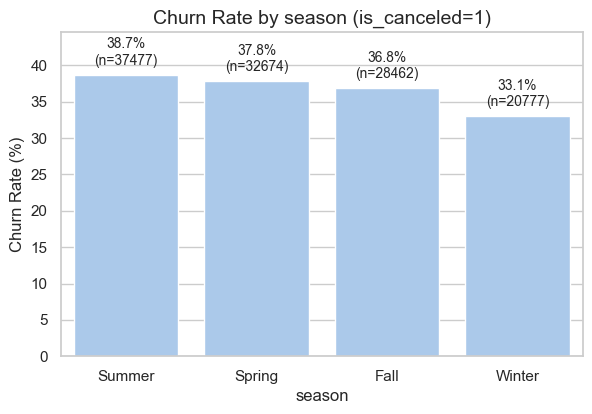

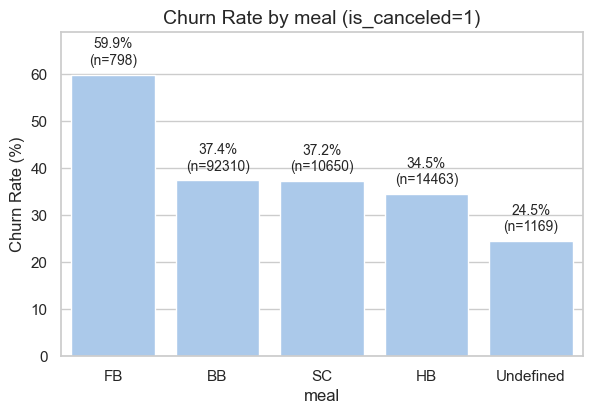

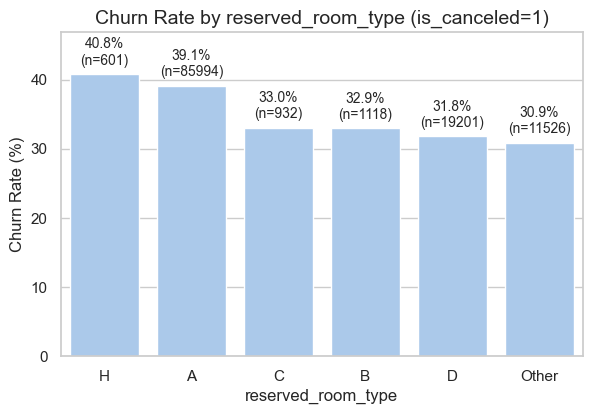

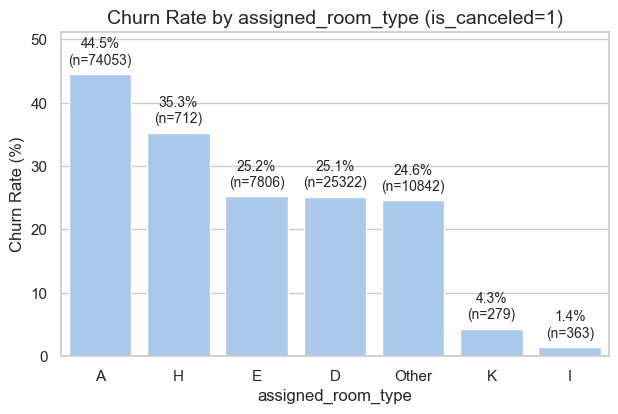

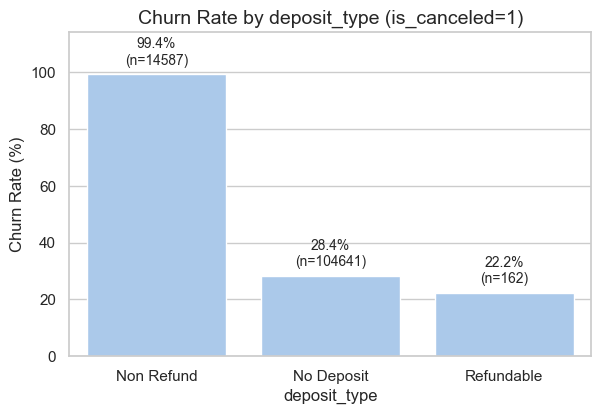

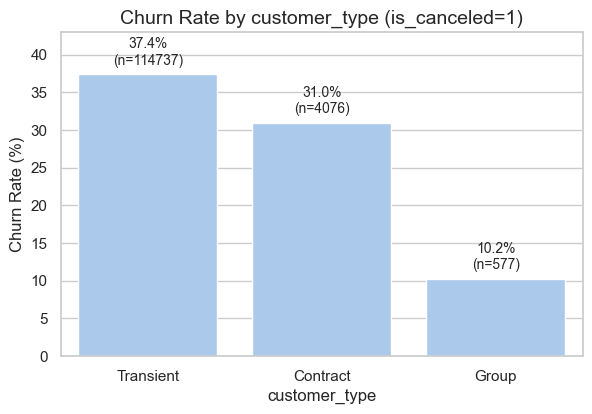

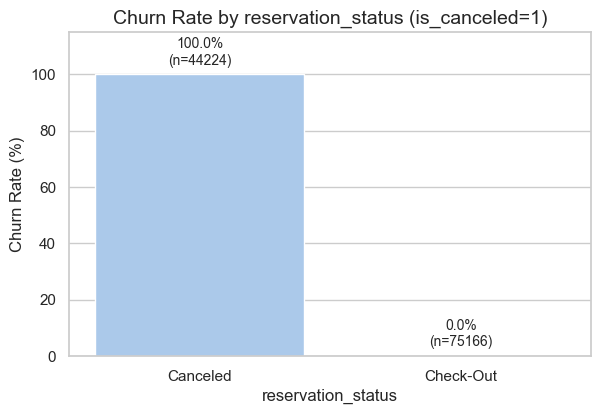

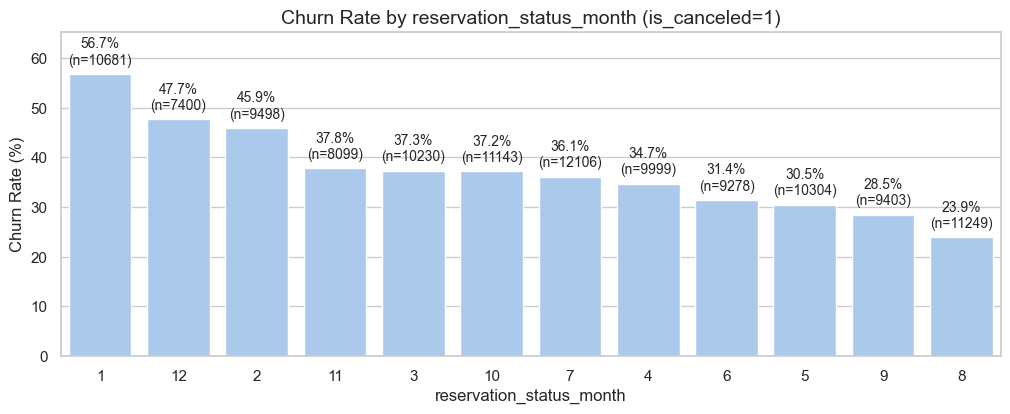

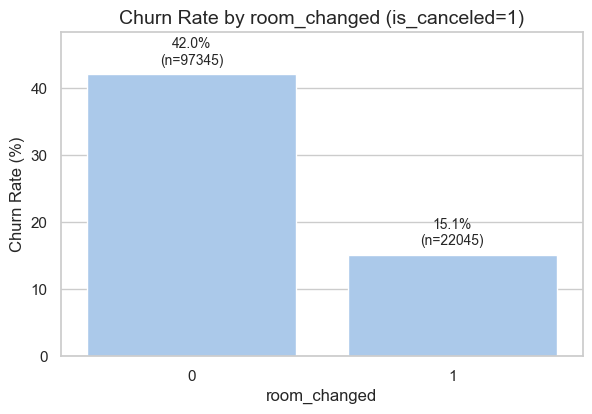

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 1. 전처리
# -----------------------------

# 1) arrival_date_month → 계절
month_to_season = {
    'January':'Winter','February':'Winter','March':'Spring',
    'April':'Spring','May':'Spring','June':'Summer',
    'July':'Summer','August':'Summer','September':'Fall',
    'October':'Fall','November':'Fall','December':'Winter'
}
df['season'] = df['arrival_date_month'].map(month_to_season)

# 2) meal - BB, HB, FB, SC 그대로 사용
# 필요하면 비율 낮은 건 'BB' 그룹으로 통합 가능
# 예: df['meal'] = df['meal'].replace({'HB':'BB','FB':'BB','SC':'BB'}) # 옵션

# 3) reserved_room_type / assigned_room_type - 비율 낮은 코드 묶기
low_room_types_reserved = ['E','F','G']   # 비율 5% 이하
low_room_types_assigned = ['C','B','F','G']  # 비율 낮은 assigned

df['reserved_room_type'] = df['reserved_room_type'].replace(low_room_types_reserved, 'Other')
df['assigned_room_type'] = df['assigned_room_type'].replace(low_room_types_assigned, 'Other')

# 4) deposit_type - 0.1% 미만 카테고리 'No Deposit'으로 통합
df['deposit_type'] = df['deposit_type'].replace({'Non Refund': 'Non Refund', 'Refundable': 'Refundable', 'No Deposit':'No Deposit'})

# 5) customer_type - Transient + Transient-Party 묶기
df['customer_type'] = df['customer_type'].replace({'Transient-Party':'Transient'})

# 6) reservation_status - No-Show(1%) → Canceled에 합치기
df['reservation_status'] = df['reservation_status'].replace({'No-Show':'Canceled'})

# 7) reservation_status_date - 문자열 → datetime, 월 단위로 추출
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])
df['reservation_status_month'] = df['reservation_status_date'].dt.month

# 8) 예약 대비 제공 방 차이
df['room_changed'] = (df['reserved_room_type'] != df['assigned_room_type']).astype(int)

# -----------------------------
# 2. 범주형 컬럼 리스트
# -----------------------------
cat_cols = ['hotel', 'season', 'meal', 'reserved_room_type', 
            'assigned_room_type', 'deposit_type', 'customer_type',
            'reservation_status', 'reservation_status_month', 'room_changed']

target = 'is_canceled'

# -----------------------------
# 3. 시각화 함수
# -----------------------------
def plot_churn_rate_by_category(df, col, target='is_canceled', min_count=20):
    # 각 범주별 표본 수와 이탈률
    g = df.groupby(col)[target]
    stats = pd.DataFrame({
        'n': g.size(),
        'churn_rate': g.mean() * 100
    }).reset_index()

    # 표본수가 너무 적은것은 제외하여 과도한 변동성 방지
    stats = stats.sort_values('churn_rate', ascending=False)
    stats_f = stats[stats['n'] >= min_count] if min_count else stats

    # 막대 그래프 그리기
    plt.figure(figsize=(max(6, 0.9*len(stats_f)), 4))
    ax = sns.barplot(data=stats_f, x=col, y='churn_rate', order=stats_f[col])
    plt.title(f'Churn Rate by {col} (is_canceled=1)', fontsize=14)
    plt.ylabel('Churn Rate (%)'); plt.xlabel(col)
    
    # 각 막대 위에 비율 표시
    for p, (_, r) in zip(ax.patches, stats_f.iterrows()):
        ax.annotate(f"{r['churn_rate']:.1f}%\n(n={int(r['n'])})",
                    (p.get_x() + p.get_width()/2., p.get_height()),
                    ha='center', va='bottom', fontsize=10, xytext=(0, 5),
                    textcoords='offset points')
    plt.ylim(0, max(5, stats_f['churn_rate'].max()*1.15))
    plt.xticks(rotation=0)
    plt.show()

    return stats # 표로 확인이 가능

# -----------------------------
# 4. 실행: 각 범주형 컬럼 취소율 시각화
# -----------------------------
summary_tables = {}
for c in cat_cols:
    summary_tables[c] = plot_churn_rate_by_category(df, c, target=target, min_count=20)


season  : 계절별 취소율은 거의 비슷한 값을 가짐 버림
month season이랑 
 meal은 0.7%율로 모든 3식을 제공하는 곳에서 취소율이 높음.....
그 외에는 취소율이 비슷하여 버릴지 말지 고민해야 할거같음

예약한 방과 제공받은 방의 예약률이 다르게 나타남 하나로 엮어서 머신러닝을 시키는게 좋아보임
방이 바뀐경우 취소율이 낮음 조금 다른 결과가 나오는 것으로 보임

보증금 좋아보임


애초에 취소율은 볼......... 필요가 있나....?
취소를 한것과 비교하면 양의 상관계수가 아닐까

겨울에 예약 취소율이 높음 월단위로 추출하는것이랑 month season과 차이가 나는 이유가 뭘까.

num_cols = [
    'lead_time',
    'arrival_date_year',
    'arrival_date_day_of_month',
    'stays_in_weekend_nights',
    'stays_in_week_nights',  # → 합쳐 total_stays로 만들어도 가능
    'adults',
    'children',
    'babies',                # → 합쳐 total_guests로 만들어도 가능
    'is_repeated_guest',
    'previous_cancellations',
    'previous_bookings_not_canceled',
    'booking_changes',
    'days_in_waiting_list',
    'adr',
    'required_car_parking_spaces',
    'total_of_special_requests'
]

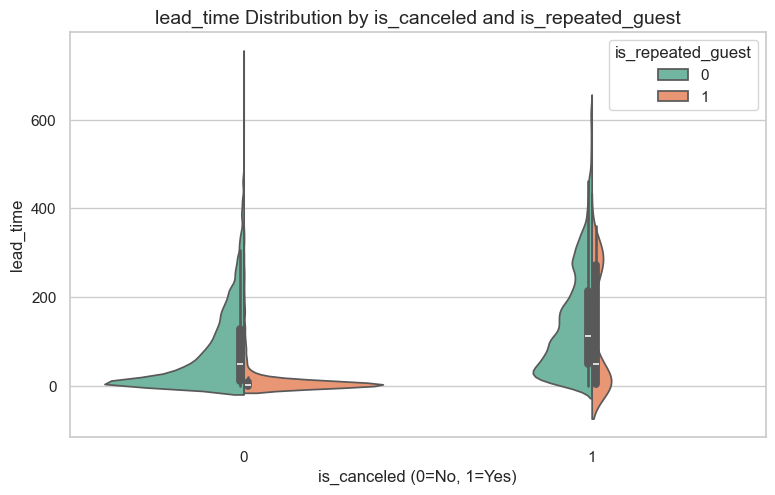

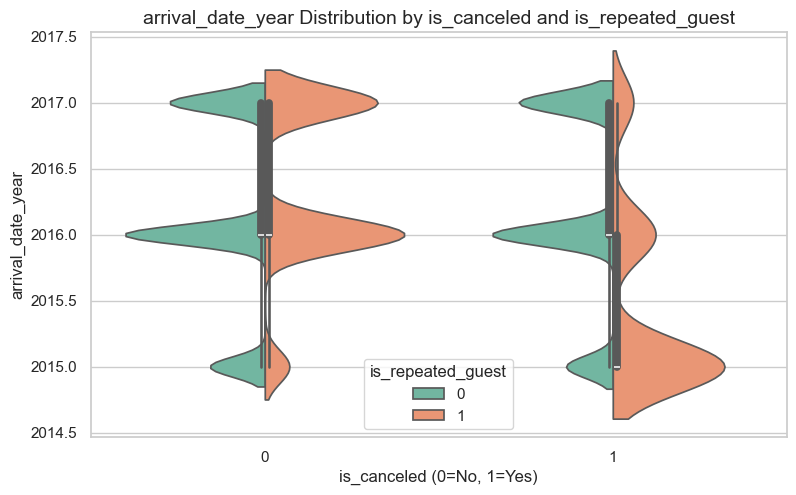

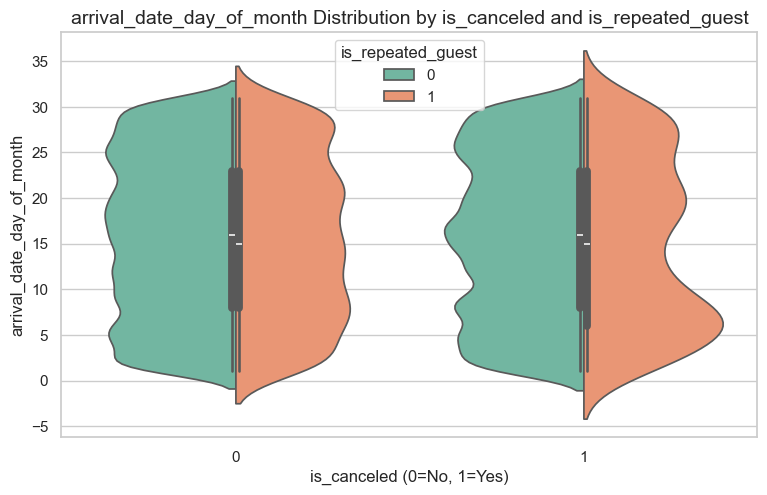

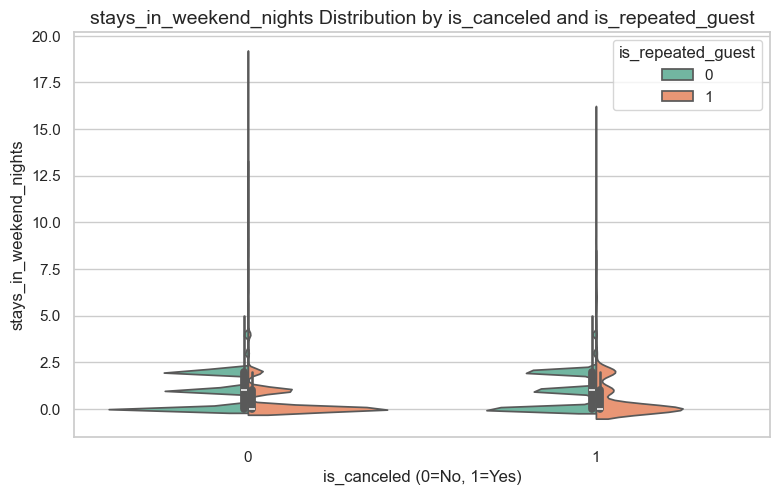

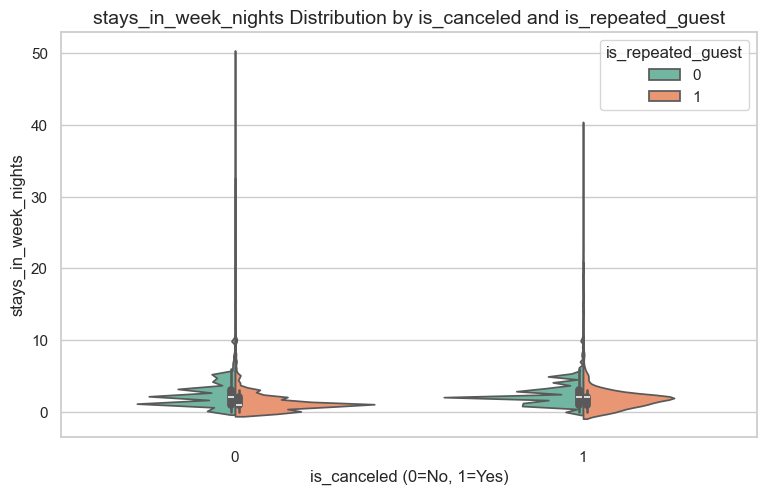

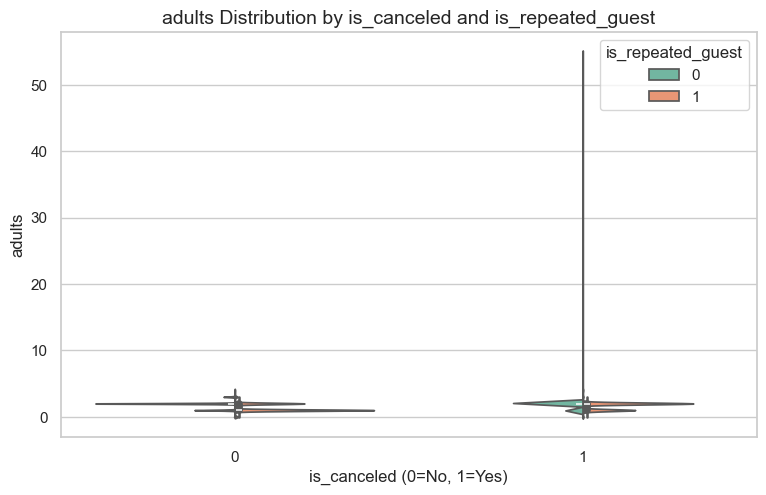

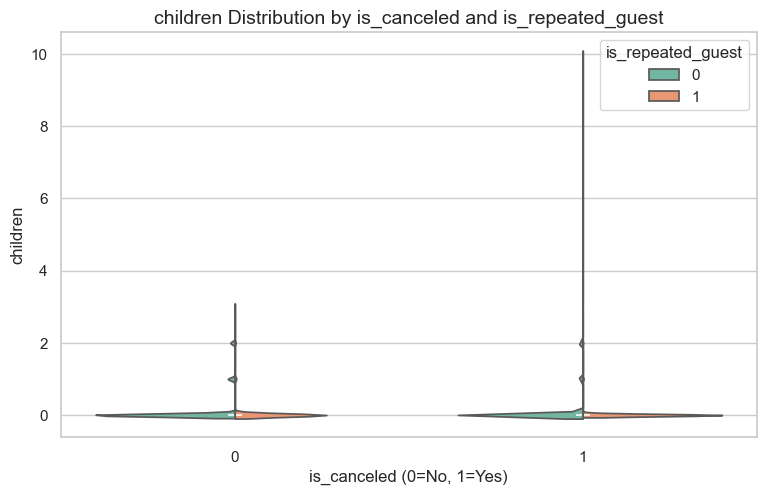

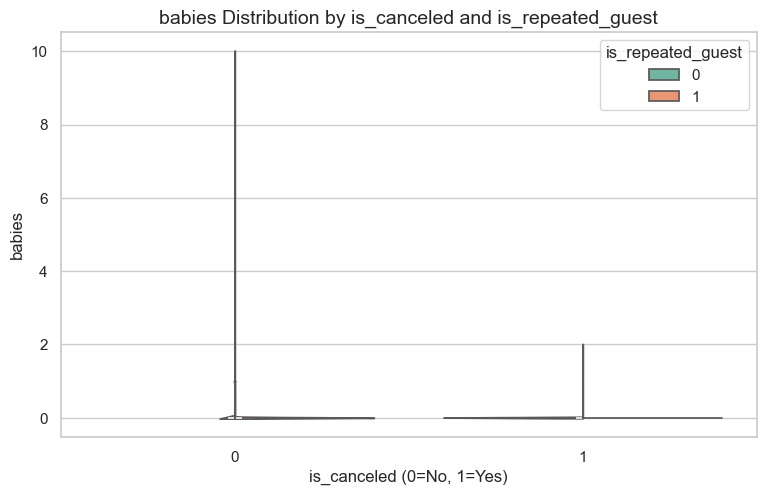

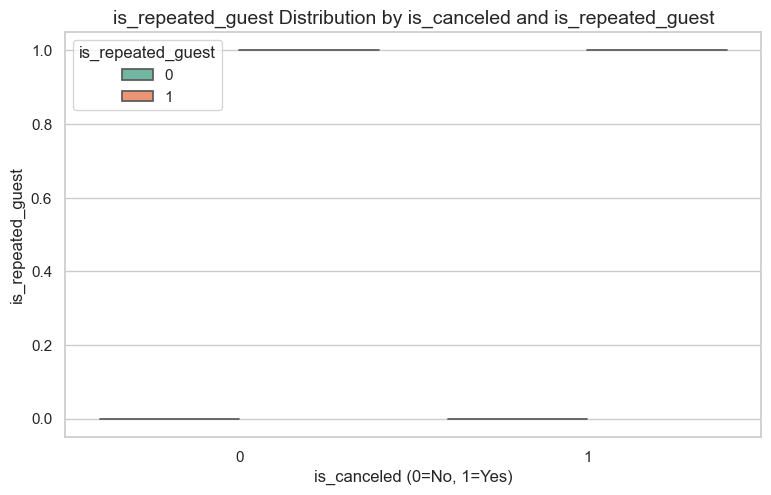

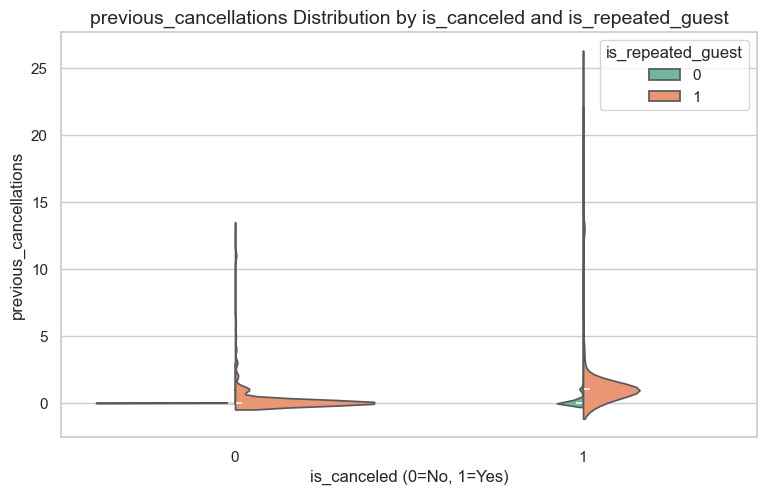

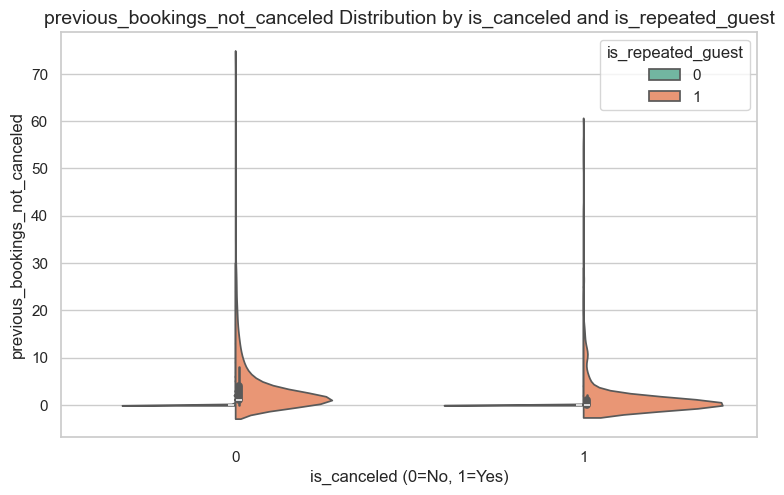

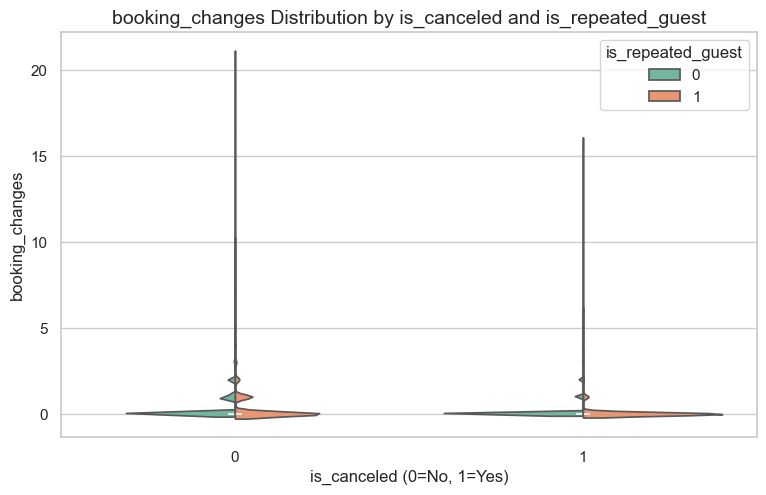

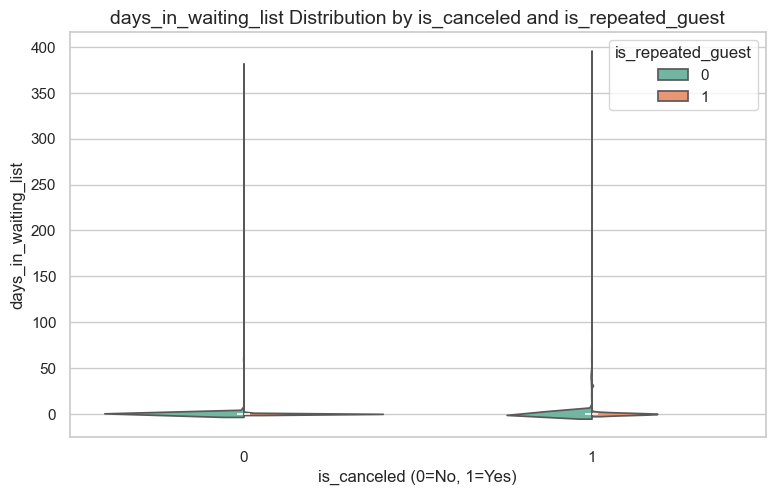

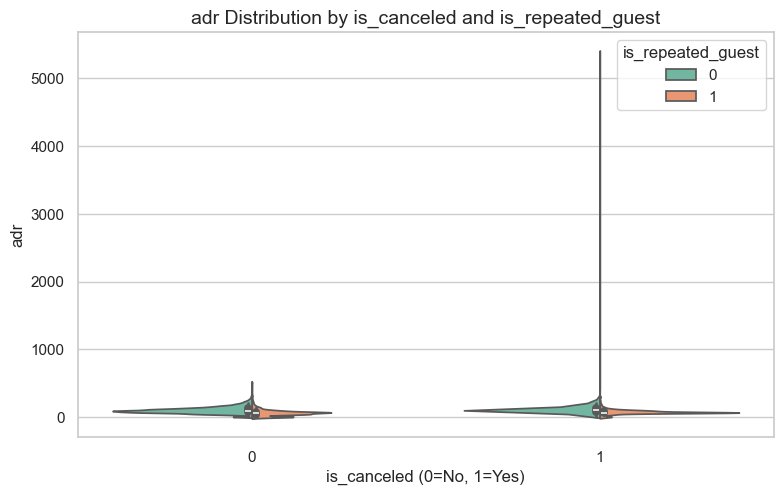

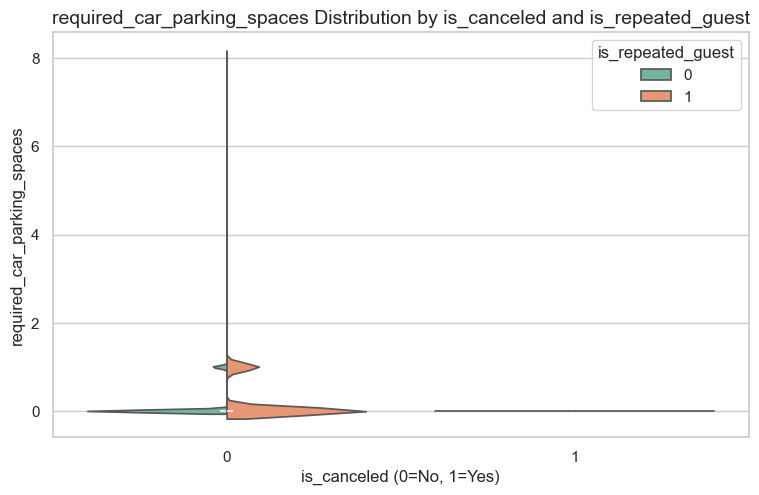

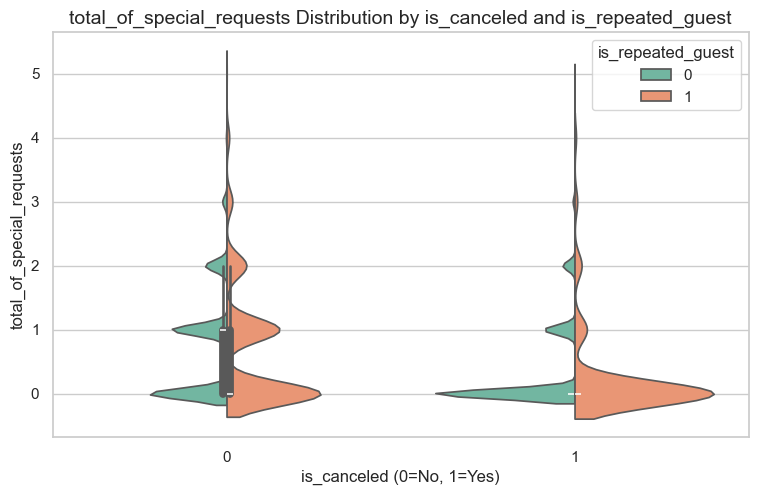

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = [
    'lead_time',
    'arrival_date_year',
    'arrival_date_day_of_month',
    'stays_in_weekend_nights',
    'stays_in_week_nights',  # → 합쳐 total_stays로 만들어도 가능
    'adults',
    'children',
    'babies',                # → 합쳐 total_guests로 만들어도 가능
    'is_repeated_guest',
    'previous_cancellations',
    'previous_bookings_not_canceled',
    'booking_changes',
    'days_in_waiting_list',
    'adr',
    'required_car_parking_spaces',
    'total_of_special_requests'
]
sns.set(style="whitegrid", palette="pastel")
plt.rcParams['figure.figsize'] = (8, 5)

# Violinplot: 예약 취소 여부(is_canceled) + Complain 대신 다른 기준도 가능
for col in num_cols:
    plt.figure(figsize=(8,5))
    sns.violinplot(
        data=df,
        x='is_canceled',       # 예약 취소 여부
        y=col,
        hue='is_repeated_guest',  # 재방문 여부 같은 보조 기준 (없으면 빼도 됨)
        split=True,
        palette='Set2'
    )
    plt.title(f'{col} Distribution by is_canceled and is_repeated_guest', fontsize=14)
    plt.xlabel('is_canceled (0=No, 1=Yes)')
    plt.ylabel(col)
    plt.show()
    
# is_repeated_guest 0 = 신규, 1 = 재방문


리드타임 (lead_time)

예약을 오래 전에 한 고객일수록(리드타임이 길수록) 취소 확률이 높음.

반대로 당일 또는 짧은 기간 전 예약은 거의 취소되지 않음.
→ 핵심 지표.

재방문 여부 (is_repeated_guest)

재방문 고객은 취소율이 확실히 낮음.

신규 고객이 대부분 취소를 일으킴.
→ 충성 고객은 안전한 예약군.

이전 취소 기록 (previous_cancellations)

과거에 취소 경험이 있는 고객은 또 취소할 확률이 매우 높음.
→ 과거 행동이 강력한 지표.

ADR(평균 숙박 요금)

요금이 비정상적으로 높거나 낮은 경우 취소 확률이 높음.

정상적인 가격대에서는 차이가 크지 않음.
→ 가격 민감 고객은 불안정.

예약 변경 횟수 (booking_changes)

예약을 여러 번 바꾼 고객일수록 취소 위험이 높음.

안정적인 예약은 거의 변동 없음.

대기일수 (days_in_waiting_list)

대기 시간이 길었던 예약은 취소 확률이 높음.
→ “기다림”은 불만족 요인.

특별 요청 수 (total_of_special_requests)

요청이 많을수록 취소율이 낮음.

구체적으로 요구사항을 남긴 고객은 예약 의도가 확실함.

주차 공간 요청 (required_car_parking_spaces)

가족 단위(차를 동반한) 고객은 예약을 유지할 확률이 높음.

투숙객 수 (adults, children, babies)

대체로 취소와 큰 상관은 없음.

단체(성인 수가 비정상적으로 많은 경우)는 취소 위험이 있음.

체류 기간 (stays_in_weekend_nights / stays_in_week_nights)

대부분 1~3일 숙박, 큰 차이는 없음.

아주 긴 체류(일주일 이상)는 일부 취소가 존재.

취소 가능성이 높은 고객 특징  
신규 고객  
리드타임이 긴 예약  
이전에 취소한 이력이 있는 고객  
ADR이 극단적으로 높은/낮은 고객  
예약 변경이 잦은 고객  
대기일수가 긴 예약  
취소 가능성이 낮은 고객 특징  
재방문 고객  
특별 요청을 여러 개 남긴 고객  
주차 공간을 요구한 고객(가족 단위)  
과거에 예약을 잘 유지했던 고객  

일부 그래프 형태가 이상하게 찍힌 것을 보아 이상치가 있을 것으로 보임

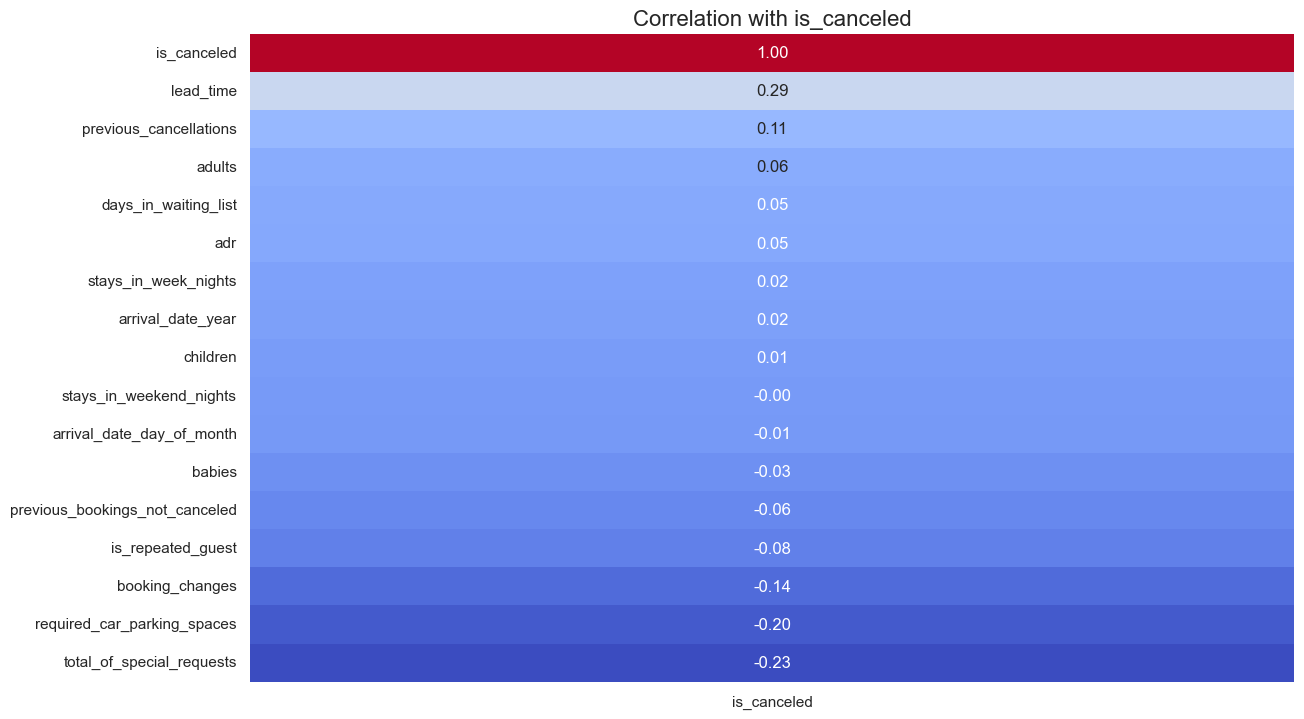

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# 상관계수 계산 (is_canceled 포함)
corr = df[num_cols + ['is_canceled']].corr()

# 히트맵 그리기
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr[['is_canceled']].sort_values(by='is_canceled', ascending=False), 
    annot=True, fmt=".2f", cmap='coolwarm', cbar=False
)
plt.title("Correlation with is_canceled", fontsize=16)
plt.show()
